<a href="https://colab.research.google.com/github/KrushanthAmalanathan/DL-Lab7/blob/main/Gridworld_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 12
        self.width = 12
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        # type your code here
        # Epsilon-greedy policy
        if np.random.uniform(0, 1) < self.epsilon:
            action = np.random.choice(available_actions)
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            max_q_value = max(q_values_of_state.values())

            # Find all actions with the maximum Q-value
            actions_with_max_q = [action for action, q_value in q_values_of_state.items() if q_value == max_q_value]

            # Choose randomly among actions with the maximum Q-value
            action = np.random.choice(actions_with_max_q)

        return action

    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
       #type your code here
        old_q_value = self.q_table[old_state][action]
        max_future_q = max(self.q_table[new_state].values())
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * max_future_q - old_q_value)
        self.q_table[old_state][action] = new_q_value

In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = DOWN
Reward obtained = -1.0
Current position of the agent = (5, 4)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

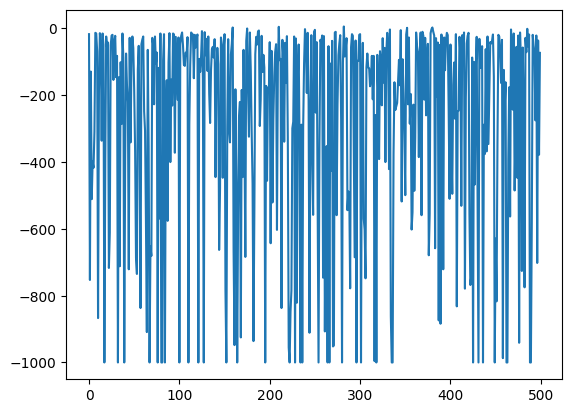

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

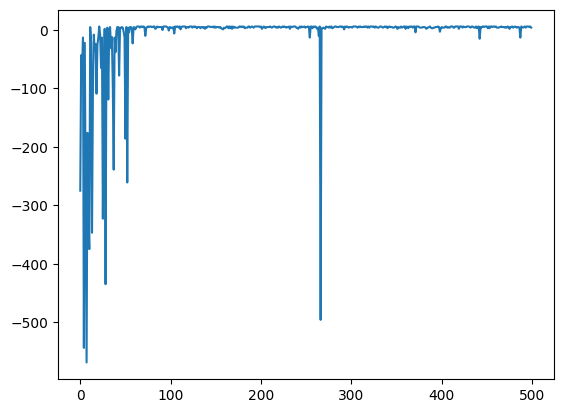

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

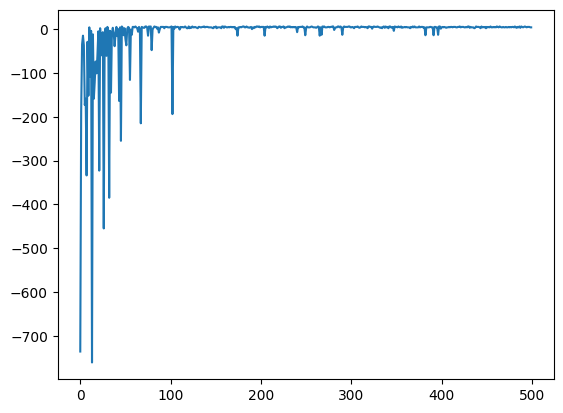

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.4
	DOWN
		-0.4181
	LEFT
		-0.30000000000000004
	RIGHT
		-0.37720000000000004
(0, 1)
	UP
		-0.2
	DOWN
		-0.2
	LEFT
		-0.2
	RIGHT
		3.010139117819556
(0, 2)
	UP
		4.163882655545787
	DOWN
		2.0480839304567624
	LEFT
		0.09118970593990161
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		1.5664204024616297
	DOWN
		-0.1
	LEFT
		9.576088417247838
	RIGHT
		0
(0, 5)
	UP
		-0.1
	DOWN
		-0.1
	LEFT
		3.616487334999781
	RIGHT
		-0.1
(0, 6)
	UP
		-0.30000000000000004
	DOWN
		-0.30090000000000006
	LEFT
		-0.05446198761948995
	RIGHT
		-0.3271
(0, 7)
	UP
		-0.6
	DOWN
		-0.6205057
	LEFT
		-0.536402
	RIGHT
		-0.5173800000000001
(0, 8)
	UP
		-0.6993062
	DOWN
		-0.7047883600000001
	LEFT
		-0.6497373000000001
	RIGHT
		-0.70978049
(0, 9)
	UP
		-0.7999999999999999
	DOWN
		-0.8026190180000001
	LEFT
		-0.7563796100000002
	RIGHT
		-0.7248148010000001
(0, 10)
	UP
		-0.7999999999999999
	DOWN
		-0.798311879
	LEFT
		-0.7785343600000001
	RIGHT
		-0.8005314410000001


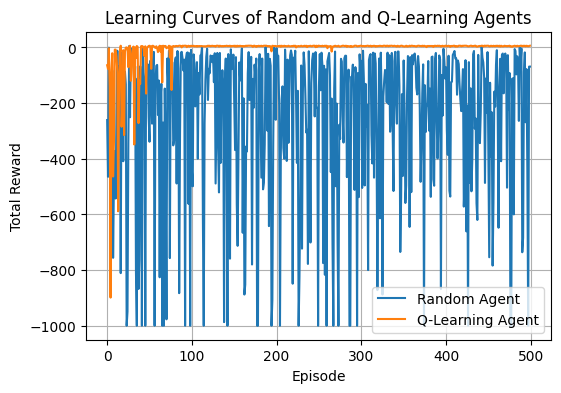

In [ ]:
# Run random agent and get rewards
environment_random = GridWorld()
random_agent = RandomAgent()
reward_per_episode_random = play(environment_random, random_agent, trials=500)

# Run Q-learning agent and get rewards
environment_q = GridWorld()
agentQ = Q_Agent(environment_q)
reward_per_episode_q = play(environment_q, agentQ, trials=500, learn=True)

# Plot learning curves
plt.figure(figsize=(6, 4))
plt.plot(reward_per_episode_random, label='Random Agent')
plt.plot(reward_per_episode_q, label='Q-Learning Agent')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curves of Random and Q-Learning Agents')
plt.legend()
plt.grid(True)
plt.show()

Saving download.png to download.png


(np.float64(-0.5), np.float64(560.5), np.float64(392.5), np.float64(-0.5))

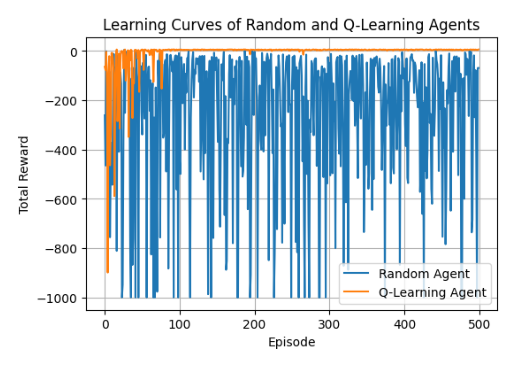

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload file
uploaded = files.upload()

# Display the uploaded image
image_name = list(uploaded.keys())[0]
img = Image.open(image_name)
plt.imshow(img)
plt.axis('off')

In [ ]:
uploaded = files.upload()

# Display the uploaded image
image_name = list(uploaded.keys())[0]
img = Image.open(image_name)
plt.imshow(img)
plt.axis('off')

In [ ]:
pip install torch matplotlib numpy

ERROR: Invalid requirement: 'matplotlib\xa0numpy': Expected end or semicolon (after name and no valid version specifier)
    matplotlib numpy
              ^


Training with epsilon = 0.1
Training with epsilon = 0.5
Training with epsilon = 0.9


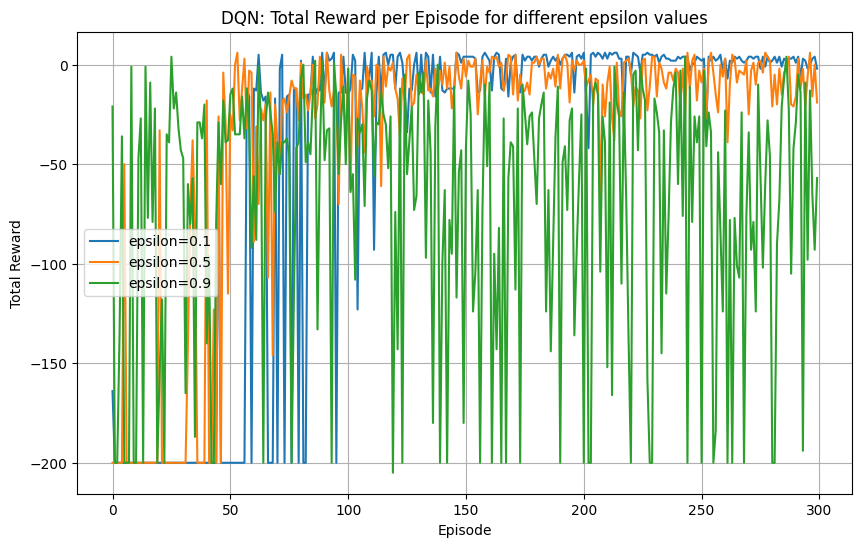

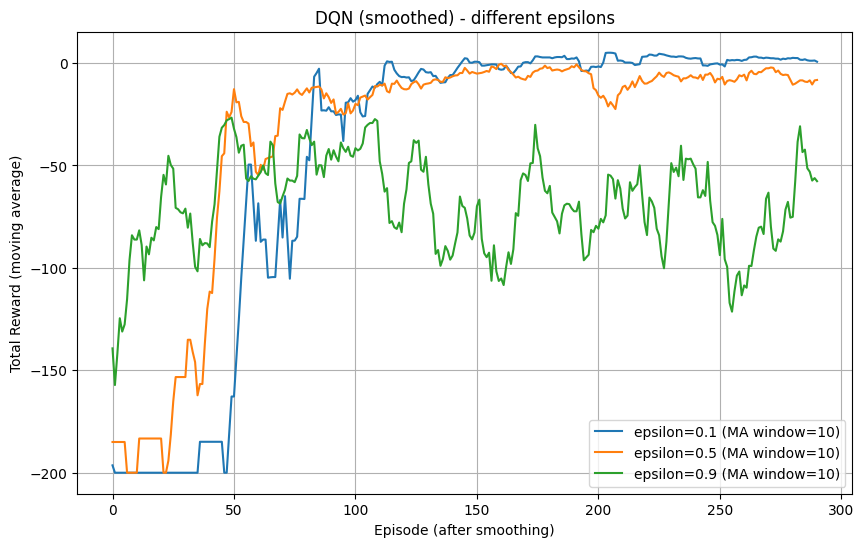

Saved plots to: results/dqn_learning_curves.png and results/dqn_learning_curves_smoothed.png


In [ ]:
# dqn_gridworld.py
# Deep Q-Learning (DQN) for the GridWorld environment provided in the lab.
# Trains DQN for epsilon in {0.1, 0.5, 0.9} and saves learning curve plots.

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple

# -------------------------
# GridWorld (same behaviour as your lab)
# -------------------------
class GridWorld:
    def __init__(self):
        self.height = 12
        self.width = 12
        self.grid = np.zeros(( self.height, self.width)) - 1
        self.current_location = ( 4, np.random.randint(0,5))
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        return self.grid[ new_location[0], new_location[1]]

    def make_step(self, action):
        last_location = self.current_location
        if action == 'UP':
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'DOWN':
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        elif action == 'LEFT':
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)
        elif action == 'RIGHT':
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
        return reward

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# -------------------------
# Replay buffer
# -------------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=5000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

# -------------------------
# Neural net approximator
# -------------------------
class DQN(nn.Module):
    def __init__(self, input_dim=2, output_dim=4, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# state representation: normalized (x, y)
def state_from_location(loc, env):
    x, y = loc
    return np.array([x / (env.height - 1), y / (env.width - 1)], dtype=np.float32)

action_map = {0: 'UP', 1: 'DOWN', 2: 'LEFT', 3: 'RIGHT'}

# -------------------------
# DQN agent
# -------------------------
class DQNAgent:
    def __init__(self, env, epsilon=0.1, lr=1e-3, gamma=0.99, buffer_capacity=5000, batch_size=64, target_update=10):
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(capacity=buffer_capacity)
        self.policy_net = DQN(input_dim=2, output_dim=4, hidden=64)
        self.target_net = DQN(input_dim=2, output_dim=4, hidden=64)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.target_update = target_update

    def select_action(self, state_np):
        if random.random() < self.epsilon:
            return random.randrange(4)
        state_t = torch.from_numpy(state_np).unsqueeze(0)
        with torch.no_grad():
            qvals = self.policy_net(state_t)
            return int(qvals.argmax(dim=1).item())

    def optimize(self):
        if len(self.buffer) < self.batch_size:
            return None
        transitions = self.buffer.sample(self.batch_size)
        states = torch.tensor(transitions.state, dtype=torch.float32)
        actions = torch.tensor(transitions.action, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(transitions.reward, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(transitions.next_state, dtype=torch.float32)
        dones = torch.tensor(transitions.done, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return float(loss.item())

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# -------------------------
# Training routine
# -------------------------
def train_dqn(epsilon, episodes=300, max_steps=200, seed=42,
              lr=1e-3, gamma=0.99, buffer_capacity=5000, batch_size=64, target_update=10):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = GridWorld()
    agent = DQNAgent(env, epsilon=epsilon, lr=lr, gamma=gamma,
                     buffer_capacity=buffer_capacity, batch_size=batch_size, target_update=target_update)

    rewards_per_episode = []
    losses = []

    for ep in range(episodes):
        env.__init__()  # reset env (keeps random start behavior)
        state = state_from_location(env.current_location, env)
        total_reward = 0.0
        for t in range(max_steps):
            action_idx = agent.select_action(state)
            action_str = action_map[action_idx]
            reward = env.make_step(action_str)
            done = (env.check_state() == 'TERMINAL')
            next_state = state_from_location(env.current_location, env)
            agent.buffer.push(state, action_idx, reward, next_state, float(done))
            loss = agent.optimize()
            if loss is not None:
                losses.append(loss)
            state = next_state
            total_reward += reward
            if done:
                break

        if (ep + 1) % agent.target_update == 0:
            agent.update_target()

        rewards_per_episode.append(total_reward)

    return rewards_per_episode, losses, agent

# -------------------------
# Experiment: three epsilons
# -------------------------
if __name__ == "__main__":
    import os
    epsilons = [0.1, 0.5, 0.9]
    episodes = 300       # adjust smaller (150) if you need faster runs
    results = {}
    for eps in epsilons:
        print(f"Training with epsilon = {eps}")
        rewards, losses, trained_agent = train_dqn(epsilon=eps, episodes=episodes,
                                                   max_steps=200, seed=42,
                                                   lr=1e-3, gamma=0.99,
                                                   buffer_capacity=5000, batch_size=64, target_update=10)
        results[eps] = {'rewards': rewards, 'losses': losses, 'agent': trained_agent}

    # Plot raw rewards
    plt.figure(figsize=(10,6))
    for eps in epsilons:
        plt.plot(results[eps]['rewards'], label=f'epsilon={eps}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN: Total Reward per Episode for different epsilon values')
    plt.legend()
    plt.grid(True)
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/dqn_learning_curves.png')
    plt.show()

    # Plot smoothed (moving average)
    def moving_average(x, w=10):
        if len(x) < w:
            return x
        return np.convolve(x, np.ones(w)/w, mode='valid')

    plt.figure(figsize=(10,6))
    for eps in epsilons:
        ma = moving_average(results[eps]['rewards'], w=10)
        plt.plot(ma, label=f'epsilon={eps} (MA window=10)')
    plt.xlabel('Episode (after smoothing)')
    plt.ylabel('Total Reward (moving average)')
    plt.title('DQN (smoothed) - different epsilons')
    plt.legend()
    plt.grid(True)
    plt.savefig('results/dqn_learning_curves_smoothed.png')
    plt.show()

    print("Saved plots to: results/dqn_learning_curves.png  and results/dqn_learning_curves_smoothed.png")

In [ ]:
# Example of how to get Q-values from the DQN for a given state
# Let's take the starting state (4, random_initial_column)
# Assuming the environment object 'env' from the previous run is available
initial_state_location = env.current_location # Get the last initial state location from the environment
initial_state_np = state_from_location(initial_state_location, env)
initial_state_t = torch.from_numpy(initial_state_np).unsqueeze(0)

# Get the trained agent for epsilon=0.1 from the results dictionary
agent_epsilon_0_1 = results[0.1]['agent']

# Get the predicted Q-values for the initial state
with torch.no_grad():
    q_values_initial_state = agent_epsilon_0_1.policy_net(initial_state_t)

print(f"Q-values for initial state {initial_state_location} (normalized: {initial_state_np}):")
for i, action in action_map.items():
    print(f"  {action}: {q_values_initial_state[0, i].item()}")

# You can repeat this for different states to see how the predicted Q-values change.
# However, remember these are approximations from the neural network, not exact values from a table.